# Import and load dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
import os
import gensim
import pickle
import matplotlib.pyplot as plt

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#This dataset contains new features, ascii text converted to unicode and standardized
nrows= 5000
train = pd.read_csv('Data/train_processed_stage1.csv', nrows=nrows)
print('Train dataset contains {} rows and {} columns'.format(*train.shape))

Train dataset contains 5000 rows and 39 columns


In [3]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
meta_features_cols = ['total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks', 'num_question_marks', \
 'num_punctuation', 'num_symbols', 'num_words', 'num_unique_words', 'words_vs_unique', 'num_smilies', 'ant_slash_n', \
 'nb_fk', 'nb_sk', 'nb_dk', 'nb_you', 'nb_ng', 'nb_mother', 'start_with_columns', 'has_timestamp', 'has_date_long', \
 'has_date_short', 'has_http', 'has_mail', 'has_image', 'has_ip', 'has_emphasize_equal', 'has_emphasize_quotes', \
 'has_star', 'unknown_fasttext']

X_clean_text_df = train[['id','clean_text']].fillna('something')
X_meta_feats_df = train[meta_features_cols].fillna('something')
y = train[class_names]
print ('X_clean_text_df contains {} rows and {} columns'.format(*X_clean_text_df.shape))
print ('X_meta_feats_df contains {} rows and {} columns'.format(*X_meta_feats_df.shape))
print ('y contains {} rows and {} columns'.format(*y.shape))

X_clean_text_df contains 5000 rows and 2 columns
X_meta_feats_df contains 5000 rows and 30 columns
y contains 5000 rows and 6 columns


In [4]:
X_clean_text_df.head()

,id,clean_text
0,0000997932d777bf,explanation why the edits made under my userna...
1,000103f0d9cfb60f,d aww ! he matches this background colour i am...
2,000113f07ec002fd,hey man i am really not trying to edit war it ...
3,0001b41b1c6bb37e,more i can not make any real suggestions on im...
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...


In [5]:
X_meta_feats_df.head()

,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique,...,has_date_long,has_date_short,has_http,has_mail,has_image,has_ip,has_emphasize_equal,has_emphasize_quotes,has_star,unknown_fasttext
0,-0.220195,-0.001654,0.137572,-0.025546,0.346388,-0.154587,-0.107151,-0.244618,-0.130379,0.768235,...,-0.081772,-0.112575,-0.129103,-0.028225,-0.008183,1.340625,-0.044091,-0.00468,-0.051793,-0.20777
1,-0.477509,-0.094891,0.213346,0.013065,-0.282584,-0.232894,-0.107151,-0.506634,-0.571261,1.131109,...,-0.081772,-0.112575,-0.129103,-0.028225,-0.008183,-0.172487,-0.044091,-0.00468,-0.051793,-0.20777
2,-0.272673,-0.136330,-0.371132,-0.025546,-0.282584,-0.311200,-0.107151,-0.254695,-0.167119,0.573838,...,-0.081772,-0.112575,-0.129103,-0.028225,-0.008183,-0.172487,-0.044091,-0.00468,-0.051793,-0.20777
3,0.385847,-0.063812,-0.365558,-0.025546,-0.282584,-0.154587,-0.107151,0.460811,0.622796,-1.009204,...,-0.081772,-0.112575,-0.129103,-0.028225,-0.008183,-0.172487,-0.044091,-0.00468,-0.051793,-0.20777
4,-0.553687,-0.157049,-0.234513,-0.025546,0.346388,-0.389507,-0.107151,-0.546945,-0.644741,1.131109,...,-0.081772,-0.112575,-0.129103,-0.028225,-0.008183,-0.172487,-0.044091,-0.00468,-0.051793,-0.20777


In [6]:
y.head(8)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0


# Convert clean_text to vectors/tokenize

In [7]:
#This allows to vectorize a text corpus, by turning each text into a sequence of integers 
src_vocab_size = 10000
# src_vocab_size = 283759
def create_tokenizer():
    #consider only the top 10000 words in the dataset
    tokenizer = text.Tokenizer(num_words=src_vocab_size)
    tokenizer.fit_on_texts(list(X_clean_text_df['clean_text']))
    return tokenizer

def find_max_len(percentile=0.9):
    #since each of the reviews can be of varying length. we will convert them to be of same length by padding.
    #lets find out what should be the length of each reviews
    #find the length
    X_clean_text_df['text_length'] = X_clean_text_df['clean_text'].apply(len)

    # use the 90th percentile to pad sequences
    maxlen = int(X_clean_text_df.text_length.quantile(percentile)) # 90th percentile
    return maxlen

# encode and pad sequences
def encode_sequences(tokenizer, length):
    #map words to integers as needed for modelling
    X_train_sequence = tokenizer.texts_to_sequences(X_clean_text_df['clean_text'])

    # pad sequences with 0 values
    #it will take each review and make them to be of 836 words.
    #if the review is less than 836 words it will pad zeroes at the start and append the reviews to the end.
    #if the review is more than 836 words, the words beyond 600 will be truncated
    X_train_padded_seq = sequence.pad_sequences(X_train_sequence, maxlen=length)
    return X_train_padded_seq

In [8]:
tokenizer = create_tokenizer()
print('Number of unique tokens created from the training dataset is {}'.format(len(tokenizer.word_index)))

maxlen = find_max_len()
print('Sequences will be of length - {}'.format(maxlen))

X_train_padded_seq = encode_sequences(tokenizer, maxlen)

Number of unique tokens created from the training dataset is 22966
Sequences will be of length - 837


In [9]:
X_train_padded_seq[0:2]

array([[   0,    0,    0, ...,   41, 3220,   88],
       [   0,    0,    0, ...,   37,  934,  179]])

# Preprocessing
Build an embedding matrix that can be loaded into an Embedding layer. It must be a matrix of shape (src_vocab_size, embedding_dim)

In [11]:
#understand what the file contains
EMBEDDING_FILE_FASTTEXT="Data/embeddings/crawl-300d-2M.vec"
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
cnt = 1
for o in open(EMBEDDING_FILE_FASTTEXT,encoding='utf-8'):
    if cnt > 4:
        print(o)
        print(get_coefs(*o.rstrip().rsplit(' ')))
    cnt += 1
    if cnt > 6: break

and -0.1081 0.0191 0.0354 0.0127 0.0664 -0.0126 -0.1882 0.0631 -0.2306 0.0095 0.0917 0.1513 0.0558 -0.0643 -0.0288 -0.0447 0.1603 0.0613 0.0349 -0.0578 0.0003 -0.1399 0.0163 -0.0419 -0.0487 0.0057 0.0017 -0.0268 -0.0170 0.1045 0.0815 -0.0060 0.0635 -0.1710 0.0276 -0.0230 0.0824 0.0304 -0.1595 0.0851 -0.0556 0.0329 -0.0921 0.0196 -0.0404 0.0361 -0.0843 0.1014 -0.0393 -0.1805 -0.0073 0.2247 -0.0621 -0.0575 -0.0316 0.0198 0.0602 0.1312 -0.1278 0.0177 -0.0600 -0.2904 -0.0465 -0.1078 -0.0701 -0.0497 -0.1102 0.0156 -0.0595 0.0762 0.2638 0.0353 0.0745 0.0361 -0.0561 -0.1179 -0.4751 0.0458 -0.0672 -0.0022 0.9264 0.0101 -0.1085 0.0669 -0.0417 -0.0428 0.0391 -0.0581 0.0107 -0.0873 -0.0016 0.5711 0.0345 0.0930 -0.0647 -0.0820 0.0587 -0.1307 0.0480 0.0226 0.0115 0.0296 -0.1675 0.0399 0.2511 0.0423 0.1299 -0.0336 -0.0977 0.0146 0.3527 0.0122 0.1031 -0.0657 -0.3704 0.0445 0.1242 -0.0031 0.0255 -0.0109 0.1575 0.0288 0.2549 -0.0280 0.0462 -0.0282 -0.0154 0.0405 0.3191 0.0113 -0.0136 0.0182 -0.0385 -0.

In [9]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

def create_embeddings(source_file):
    embeddings = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(source_file,encoding='utf-8'))
    return embeddings

def save_embeddings_to_file(source_file, target_file_name):
    with open(target_file_name, 'wb') as handle:
        pickle.dump(source_file, handle)

In [10]:
def load_embeddings_from_pickle_file():
    if os.path.isfile(EMBEDDING_DICT_FASTTEXT):
        #load file
        with open(EMBEDDING_DICT_FASTTEXT, 'rb') as handle:
            embeddings_index_ft = pickle.load(handle)
    else:
        embeddings_index_ft = create_embeddings(EMBEDDING_FILE_FASTTEXT)
        save_embeddings_to_file(embeddings_index_ft, EMBEDDING_DICT_FASTTEXT)
        
    if os.path.isfile(EMBEDDING_DICT_TWITTER):
        #load file
        with open(EMBEDDING_DICT_TWITTER, 'rb') as handle:
            embeddings_index_tw = pickle.load(handle)
    else:
        embeddings_index_tw = create_embeddings(EMBEDDING_FILE_TWITTER)
        save_embeddings_to_file(embeddings_index_tw, EMBEDDING_DICT_TWITTER)
    return embeddings_index_ft, embeddings_index_tw

In [11]:
# Load the FastText Web Crawl vectors
# The emebedding file contains words and its corresponding vectors. 
# For instance the word and will be stored in embedding file as
# (and -0.1081 0.0191 0.0354 0.0127 0.0664 -0.0126 -0.1882 0.0631 -0.2306 0.0095 0.0917 0.1513)
# we will create a dictionary where the word will be the key and the vectors will be an array
EMBEDDING_FILE_FASTTEXT="Data/embeddings/crawl-300d-2M.vec"
EMBEDDING_FILE_TWITTER="Data/embeddings/glove.twitter.27B.200d.txt"

EMBEDDING_DICT_FASTTEXT="Data/embeddings/embeddings_index_ft.pickle"
EMBEDDING_DICT_TWITTER="Data/embeddings/embeddings_index_tw.pickle"

# load the fasttext and twitter word embeddings file into memory as a dictionary of word to embedding array.
#This process is slow so it is better to save the files
embeddings_index_ft, embeddings_index_tw = load_embeddings_from_pickle_file()
print('Loaded {} word vectors from fasttext embeddings.'.format(len(embeddings_index_ft)))
print('Loaded {} word vectors from twitter embeddings.'.format(len(embeddings_index_tw)))

Loaded 2000000 word vectors from fasttext embeddings.
Loaded 1193514 word vectors from twitter embeddings.


In [12]:
#load spelling model. This will used to correct words that are not in the fasttext embeddings. 
import datetime
currentDT = datetime.datetime.now()
print('Start time is {}'.format(currentDT.strftime("%I:%M:%S %p")))

spell_model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE_FASTTEXT)

currentDT = datetime.datetime.now()
print('End time is {}'.format(currentDT.strftime("%I:%M:%S %p")))

Start time is 03:24:57 PM
End time is 03:34:03 PM


In [ ]:
type(spell_model)

In [13]:
# This code is  based on: Spellchecker using Word2vec by CPMP
# https://www.kaggle.com/cpmpml/spell-checker-using-word2vec

#get the list of words
words = spell_model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

#word and an index as its value
WORDS = w_rank

# Use fast text as vocabulary
def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def singlify(word):
    return "".join([letter for i,letter in enumerate(word) if i == 0 or letter != word[i-1]])

In [ ]:
#test
word_index = tokenizer.word_index
i = 1
for k,v in word_index.items():
    print(k,v)
    i +=1
    if i > 3: break

In [14]:
len(tokenizer.word_index), src_vocab_size

(22966, 10000)

In [15]:
import datetime
currentDT = datetime.datetime.now()
print('Start time is {}'.format(currentDT.strftime("%I:%M:%S %p")))


#this contain the word and its index, from the training dataset such as
# the 1
# to 2
# i 3
word_index = tokenizer.word_index

#len(word_index) is 22966 and src_vocab_size is 10000
nb_words = min(src_vocab_size, len(word_index)) + 1


# we need to create a matrix of one embedding for each word in the training dataset. We can do that by enumerating 
# all unique words in the word_index and locating the embedding weight vector from the loaded fasttext embedding. 
# The result is a matrix of weights only for words we will see during training.
# if the word is not found in the fasttext embedding we will try to correct the spelling and check
embedding_matrix = np.zeros((nb_words, 501))

#get embeddings for the word 'something' from twitter 
something_tw = embeddings_index_tw.get("something")

#get embeddings for the word 'something' from fasttext 
something_ft = embeddings_index_ft.get("something")

something = np.zeros((501,))
something[:300,] = something_ft
something[300:500,] = something_tw
something[500,] = 0

def all_caps(word):
    return len(word) > 1 and word.isupper()

def embed_word(embedding_matrix, i, word):
    embedding_vector_ft = embeddings_index_ft.get(word)
    if embedding_vector_ft is not None: 
        if all_caps(word):
            last_value = np.array([1])
        else:
            last_value = np.array([0])
        embedding_matrix[i,:300] = embedding_vector_ft
        embedding_matrix[i,500] = last_value
        embedding_vector_tw = embeddings_index_tw.get(word)
        if embedding_vector_tw is not None:
            embedding_matrix[i,300:500] = embedding_vector_tw

            
# Fasttext vector is used by itself if there is no glove vector but not the other way around.
ctr = len(word_index)
for word, i in word_index.items():
    
    if i >= src_vocab_size: continue
    
    if (ctr % 25000==0): print('{} more to go'.format(ctr))
    ctr -= 1
    
    #is the word available in fasttext, create embeddings from fasttext vectors
    #if not try to correct the word
    if embeddings_index_ft.get(word) is not None:
        embed_word(embedding_matrix,i,word)
    else:
        # change to > 20 for better score.
        if len(word) > 20:
            #use the something vectors
            embedding_matrix[i] = something
        else:
            word2 = correction(word)
            if embeddings_index_ft.get(word2) is not None:
                embed_word(embedding_matrix,i,word2)
            else:
                word2 = correction(singlify(word))
                if embeddings_index_ft.get(word2) is not None:
                    embed_word(embedding_matrix,i,word2)
                else:
                    embedding_matrix[i] = something   

currentDT = datetime.datetime.now()
print('End time is {}'.format(currentDT.strftime("%I:%M:%S %p")))

Start time is 04:23:00 PM
End time is 04:23:58 PM


# Build Model

In [16]:
from sklearn.metrics import roc_auc_score
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.max_score = 0
        self.not_better_count = 0

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=1)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            if (score > self.max_score):
                print("*** New High Score (previous: %.6f) \n" % self.max_score)
#                 model.save_weights("best_weights.h5")
                model.save_weights(bst_model_path)
                self.max_score=score
                self.not_better_count = 0
            else:
                self.not_better_count += 1
                if self.not_better_count > 3:
                    print("Epoch %05d: early stopping, high score = %.6f" % (epoch,self.max_score))
                    self.model.stop_training = True

In [17]:
def get_model(features, max_features, clipvalue=1.,num_filters=40,dropout=0.5,embedding_dims=501):
    features_input = Input(shape=(features.shape[1],))
    inp = Input(shape=(maxlen, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    #There are multiple ways to represent a word as a vector: tfidf, bag of words, one-hot encoding etc. These are high
    #dimensional sparse representation of the data. The other way to reporesent a word as a vector is us iing word embeddings-
    #these are dense vectors low dimensional vectors in the form of 256 dim, 512 dim or 1024 dimensions. Word embeddings
    #pack more information into fewer dimensions.
    #There are 2 ways to obtain word embeddings:
    #1. Learn word embeddings as part of the main task at hand such as classification.
    #2. Load a pre trained word embedding. These embeddings are useful when there is less training data.
    
    #src_vocab_size represents what top n features we are using from the dataset
    #embedding_dims represents the dimensions of the fasttext word embedding.
    #embedding_matrix contains the embedding vectors for our training dataset
    #by setting trainable=False, we are saying do not train this layer.
    
#     x = Embedding(src_vocab_size, embedding_dims, weights=[embedding_matrix], trainable=False)(inp)
    x = Embedding(max_features, embedding_dims, weights=[embedding_matrix], trainable=False)(inp)
    
    # Uncomment for best result
    # Layer 2: SpatialDropout1D(0.5)
    x = SpatialDropout1D(dropout)(x)
    
    # Uncomment for best result
    # Layer 3: Bidirectional CuDNNLSTM
    #a Bidirectional layer creates a second separate instance of the recurrent layer and uses one instance for processing
    #the input sequences in chronological order and the other instance for processing the input sequences in reversed
    #order. This looks at its input sequence both ways obtaining potentially richer reprsentations and capturing patterns
    #that may have been missed by the chronological order version alone.
    #create bidirectional layer with 40 such instances
    x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)


    # Layer 4: Bidirectional CuDNNGRU
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    # Layer 5: A concatenation of the last state, maximum pool, average pool and 
    # two features: "Unique words rate" and "Rate of all-caps words"
    
    #if you want to detect the presence of something in your sequences, max pooling seems a good option.
    #But if the contribution of the entire sequence seems important to your result, then average pooling sounds reasonable.
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, max_pool,features_input])
    
    # Layer 6: output dense layer.
    outp = Dense(6, activation="sigmoid")(x)

    model = Model(inputs=[inp,features_input], outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    
    return model

In [18]:
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Embedding, SpatialDropout1D, concatenate, Dense
# , , Dropout, Conv1D, , , 
from keras.layers import Bidirectional, LSTM, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import optimizers

model = get_model(X_meta_feats_df.values, nb_words)
print(model.summary())
plot_model(model, to_file='Data/model.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 837)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 837, 501)     5010501     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 837, 501)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 837, 80)      173440      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

In [19]:
X_meta_feats_df.shape, src_vocab_size, embedding_matrix.shape

((5000, 30), 10000, (10001, 501))

In [20]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


Start time is 04:28:46 PM
Working on fold - 1
Train on 1674 samples, validate on 826 samples
Epoch 1/2
2500/2500 [==============================] - 43s 17ms/step

 ROC-AUC - epoch: 1 - score: 0.655369 

*** New High Score (previous: 0.000000) 

Epoch 2/2
2500/2500 [==============================] - 49s 19ms/step

 ROC-AUC - epoch: 2 - score: 0.747116 

*** New High Score (previous: 0.655369) 

History is {'val_loss': [0.1314047505001179, 0.12161328042823524], 'val_acc': [0.9669087939054568, 0.9673123436170398], 'loss': [0.2533089115396765, 0.1351990788827874], 'acc': [0.9248307420646276, 0.9613699736418547]}


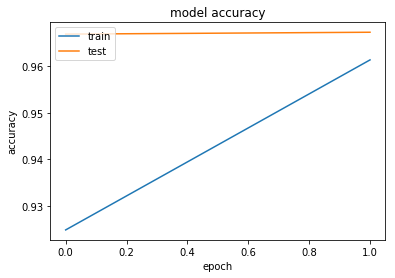

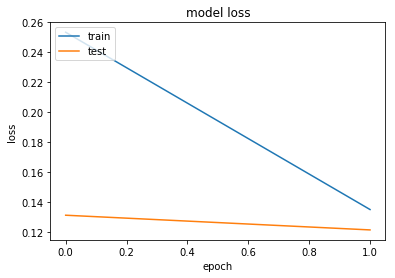

Working on fold - 2
Train on 1674 samples, validate on 826 samples
Epoch 1/2
2500/2500 [==============================] - 59s 24ms/step

 ROC-AUC - epoch: 1 - score: 0.486358 

*** New High Score (previous: 0.000000) 

Epoch 2/2
2500/2500 [==============================] - 116s 46ms/step

 ROC-AUC - epoch: 2 - score: 0.798553 

*** New High Score (previous: 0.486358) 



In [ ]:
import gc
from keras import backend as K
from sklearn.model_selection import KFold
# Checkpoint the weights when validation accuracy improves
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 


currentDT = datetime.datetime.now()
print('Start time is {}'.format(currentDT.strftime("%I:%M:%S %p")))

batch_size = 32
bst_model_path="Data\Weights\weights.best.hdf5"

# Use epochs=100 with early exiting for best score.
epochs = 2
gc.collect()
K.clear_session()

# Change to 10
num_folds = 2 #number of folds
history = History()
# predict = np.zeros((test.shape[0],6))

# Uncomment for out-of-fold predictions
# scores = []
# oof_predict = np.zeros((train.shape[0],6))

kf = KFold(n_splits=num_folds, shuffle=True, random_state=239)

ctr = 0
for train_index, test_index in kf.split(X_train_padded_seq):
    ctr += 1
    print ('Working on fold - {}'.format(ctr))
    
    
    kfold_y_train, kfold_y_test = y.iloc[train_index], y.iloc[test_index]
    kfold_X_train = X_train_padded_seq[train_index]
    kfold_X_meta_features = X_meta_feats_df.iloc[train_index]
    
    kfold_X_valid = X_train_padded_seq[test_index]
    kfold_X_valid_meta_features = X_meta_feats_df.iloc[test_index] 
    
    gc.collect()
    K.clear_session()
    
    model = get_model(X_meta_feats_df.values, nb_words)
    
    ra_val = RocAucEvaluation(validation_data=([kfold_X_valid, kfold_X_valid_meta_features], kfold_y_test), interval = 1)

    # checkpoint
#     bst_model_path="Data\Weights\weights.best.hdf5"
#     checkpoint = ModelCheckpoint(bst_model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    
#     callbacks_list = [checkpoint, ra_val]
    callbacks_list = [ra_val, history]
    
#     history = model.fit([kfold_X_train, kfold_X_meta_features], kfold_y_train, batch_size=batch_size, epochs=epochs, verbose=1,
#              callbacks = callbacks_list)
    model.fit([kfold_X_train, kfold_X_meta_features], kfold_y_train, batch_size=batch_size, epochs=epochs, verbose=1,
             callbacks = callbacks_list, validation_split=0.33)
    gc.collect()
    
    model.load_weights(bst_model_path)
    print('History is {}'.format(history.history))
    #     model.load_weights("Data\Weights\best_weights.h5")
    
#     print(history.history.keys())
    # summarize history for accuracy
    plot_history(history)
    
    
#     predict += model.predict([x_test,test_features], batch_size=batch_size,verbose=1) / num_folds
    
    #gc.collect()
    # uncomment for out of fold predictions
    #oof_predict[test_index] = model.predict([kfold_X_valid, kfold_X_valid_features],batch_size=batch_size, verbose=1)
    #cv_score = roc_auc_score(kfold_y_test, oof_predict[test_index])
    
    #scores.append(cv_score)
    #print('score: ',cv_score)

print("Done")
#print('Total CV score is {}'.format(np.mean(scores)))  
currentDT = datetime.datetime.now()
print('End time is {}'.format(currentDT.strftime("%I:%M:%S %p")))

In [59]:
type(history)

NameError: name 'history' is not defined

In [ ]:
# create the model
embedding_vecor_length = 32
model = Sequential()
#Embedding layers takes indices and returns vectors. They are used a lot in NLP tasks. You can think of this embedding layer
#as a word2vec. If you give it a number 5 it will return a vector of 5
#here we are saying take the top_words that is of 5000 words and create a vector represetation equal embedding_vector_length,
#which is of size 32. This means there will be 32 activation units in the embedding layer.
#the input is 5000 words and there are 32 activation units, so the # of params are 5000*32=160K
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
#LSTM(100) means we have 100 LSTM cells, each of these 100 LSTM cells takes each of the 32 dim vectors
#each of these LSTMs generate an output
#the number of params is - there are 32 inputs lets call this 'm' and there are 100 outputs, lets call this 'n'
#the formula is 4(nm+n^2+n) - the last n is the biases. LSTM in Keras by default has biases.
#4(3200+10000+100)=53200
model.add(LSTM(100))
#we are taking all the 100 outputs and connecting it to a sigmoid unit to generate y_i_hat.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#for a pictorial representation of this - refer to my notes
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

In [ ]:
model.fit(X_train, y_train, nb_epoch=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))